### 一、数据

数据主要包括2010年1月1日至2014年12月31日间北京pm2.5指数以及相关天气指数数据。在预处理中需要每7天抽一个数据作为验证集，其余作为测试集。

### 二、数据预处理及模型训练与验证

#### 1、数据预处理

将所有*pm2.5*列含有缺失值的数据都删除，将*cbwd*列数据独热码，并每7天抽一个数据作为验证集，其余作为测试集。

In [21]:
# import the packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

In [44]:
# data preprocessing
# read in data 
PRSA_df = pd.read_csv('./data/PRSA_data.csv')

# one-hot coding on cbwd
PRSA_df = PRSA_df.join(pd.get_dummies(PRSA_df.cbwd))

# date
PRSA_df['date'] = pd.to_datetime(PRSA_df[['year','month','day']])

# season
def season_divide(x):
    if x in range(3,6):
        return 'Spring'
    elif x in range(6,9):
        return 'Summer'
    elif x in range(9,12):
        return 'Autumn'
    else:
        return 'Winter'

PRSA_df['season'] = PRSA_df['month'].apply(season_divide)

# delete the nan statistics
no_nan_df = PRSA_df.drop(index=PRSA_df[PRSA_df['pm2.5'].isnull()].index).reset_index(drop=True)

# grade on pm2.5
no_nan_df['grade'] = no_nan_df['pm2.5'].apply(lambda x: 'low' if x<=35 else ('mid' if x<=150 else 'high'))

#### 2、pm2.5的分布和处理

In [23]:
from scipy.stats import norm
from scipy import stats

通过数据可视化直观地了解要预测的pm2.5的分布情况。很显然，要预测的pm2.5值的分布是右偏的，峰度4.7左右，与正态分布相距较远。

d:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 1.8023114189653855
Kurtosis: 4.768933321102571


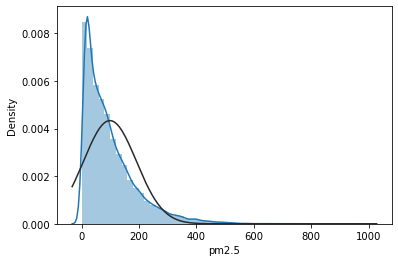

In [24]:
sns.distplot(no_nan_df['pm2.5'], fit=norm)
print("Skewness: {}".format(no_nan_df['pm2.5'].skew()))
print("Kurtosis: {}".format(no_nan_df['pm2.5'].kurt()))

通过probplot函数计算一个当前样本最可能的线性拟合，并用plt展示出来，可以看到线性拟合程度并不好。但是或许对pm2.5值做log对数处理后将会有较好的效果。

((array([-4.15033561, -3.94265485, -3.82935352, ...,  3.82935352,
          3.94265485,  4.15033561]),
  array([  0.,   0.,   1., ..., 972., 980., 994.])),
 (84.06218578546721, 98.61321455085373, 0.9131409965307454))

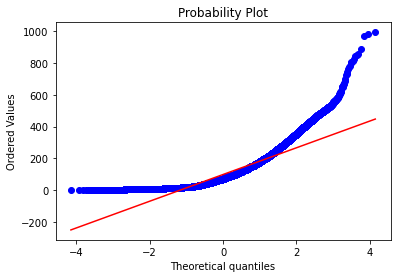

In [25]:
plt.figure()
stats.probplot(no_nan_df['pm2.5'], plot=plt)

由于log对数处理对0值会生成float infinity，故需要将pm2.5值为0的数据删除。可以看到，pm2.5为0的数据只有两条，删除影响不大。

In [28]:
no_nan_df[no_nan_df['pm2.5'] == 0]

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,date,season,grade,pm2.5_log
22304,24035,2012,9,28,10,0.0,-5,20.0,1020.0,139.48,0,0,0,1,0,0,2012-09-28,Autumn,low,-inf
22309,24040,2012,9,28,15,0.0,-10,24.0,1017.0,192.68,0,0,0,1,0,0,2012-09-28,Autumn,low,-inf


In [48]:
no_nan_df = no_nan_df.drop(no_nan_df[no_nan_df['pm2.5'] == 0].index).reset_index(drop=True)
no_nan_df['pm2.5_log'] = np.log(no_nan_df['pm2.5'])

可以看到，对pm2.5值做log对数处理后分布好多了，基本上符合了正态分布。而且也有一个比较好的线性拟合。

d:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 1.802321832311242
Kurtosis: 4.768982375083562


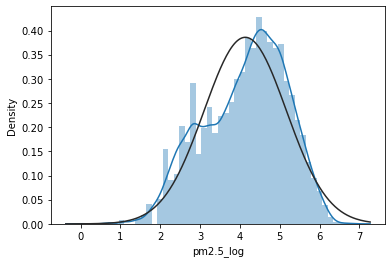

In [47]:
sns.distplot(no_nan_df['pm2.5_log'], fit=norm)
print("Skewness: {}".format(no_nan_df['pm2.5'].skew()))
print("Kurtosis: {}".format(no_nan_df['pm2.5'].kurt()))

((array([-4.15032465, -3.94264337, -3.82934173, ...,  3.82934173,
          3.94264337,  4.15032465]),
  array([0.        , 0.        , 0.        , ..., 6.8793558 , 6.88755257,
         6.90173721])),
 (1.023130250302235, 4.135784925684185, 0.9897679002754348))

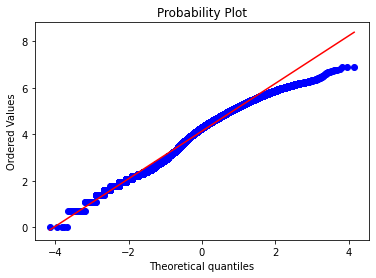

In [31]:
plt.figure()
stats.probplot(no_nan_df['pm2.5_log'], plot=plt)

提取训练数据和测试数据

In [60]:
# get the train set and test set
yy = 2010
mm = 1
dd = 7
day_of_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
test_df = pd.DataFrame()
while yy <= 2014:
    test_df = test_df.append(
        no_nan_df[(no_nan_df['year'] == yy) & (no_nan_df['month'] == mm) & (no_nan_df['day'] == dd)]
    )
    dd += 7
    if dd > day_of_month[mm - 1]:
        if yy == 2012 and mm == 2:
            dd -= 29
        dd -= day_of_month[mm - 1]
        mm += 1
    if mm > 12:
        mm -= 12
        yy += 1

train_df = no_nan_df.append(test_df).append(test_df)
train_df = train_df.drop_duplicates(keep=False)

x_var = ['DEWP','TEMP','PRES','Iws','Is','Ir','NE','NW','SE','cv']
X_train, X_test = train_df.iloc[x_var], test_df.iloc[x_var]
y_train, y_test = train_df.iloc[['pm2.5_log']], test_df.iloc[['pm2.5_log']]

ValueError: invalid literal for int() with base 10: 'DEWP'

#### 3、模型训练与验证

三种简单的线性回归模型

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [59]:
# Regression model training and test
# linear regression
lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
r2_lr = lr.score(X_test, y_test)
mse_lr = mean_squared_error(y_true=y_test, y_pred=y_pred_lr)

# ridge regression
rr = Ridge().fit(X_train, y_train)
y_pred_rr = rr.predict(X_test)
r2_rr = rr.score(X_test, y_test)
mse_rr = mean_squared_error(y_true=y_test, y_pred=y_pred_rr)

# lasso regression
las = Lasso().fit(X_train, y_train)
y_pred_las = las.predict(X_test)
r2_las = las.score(X_test, y_test)
mse_las = mean_squared_error(y_true=y_test, y_pred=y_pred_las)

ValueError: could not convert string to float: 'SE'

打印出三种模型的各种分数。

In [57]:
print('mean squre error:')
print('linear regression: {}'.format(mse_lr))
print('ridge regression: {}'.format(mse_rr))
print('lasso regression: {}'.format(mse_las))

print('R^2 score:')
print('linear regression: {}'.format(r2_lr))
print('ridge regression: {}'.format(r2_rr))
print('lasso regression: {}'.format(r2_las))

mean squre error:
linear regression: 6165.099312050266
ridge regression: 6165.10677120408
lasso regression: 6207.597103154964
R^2 score:
linear regression: 0.27635423620735255
ridge regression: 0.2763533606683246
lasso regression: 0.2713659391910581


In [ ]:
# plot to compare
fig, ax = plt.subplots(2)
ax[0].scatter([1, 2, 3], [r2_lr, r2_rr, r2_las], label='$R^2$ score')
ax[0].legend(loc='best')
ax[1].scatter([1, 2, 3], [mse_lr, mse_rr, mse_las], label='mean squared error')
ax[1].legend(loc='best')

使用支持向量机和决策树来做回归分析，以及用集成模型的Adaboost和RandomForest

In [ ]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# SVM 支持向量机
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
r2_svr = svr.score(X_test, y_test)
mse_svr = mean_squared_error(y_true=y_test, y_pred=y_pred_svr)

# Decision Tree 决策树
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)
r2_dtr = dtr.score(X_test, y_test)
mse_dtr = mean_squared_error(y_true=y_test, y_pred=y_pred_dtr)

# Adaboost
AdaBoost = AdaBoostRegressor(n_estimators=100)
AdaBoost.fit(X_train, y_train)
y_pred_ada = AdaBoost.predict(X_test)
r2_AdaBoost = AdaBoost.score(X_test, y_test)
mse_AdaBoost = mean_squared_error(y_true=y_test, y_pred=y_pred_ada)

# Random Forest 随机森林
RandomForest = RandomForestRegressor(n_estimators=20)
RandomForest.fit(X_train,y_train)
y_pred_for = AdaBoost.predict(X_test)
r2_RandomForest = RandomForest.score(X_test,y_test)
mse_RandomForest = mean_squared_error(y_true=y_test, y_pred=y_pred_for)

打印出四种模型的各种分数

In [ ]:
print('mean squre error:')
print('SVM: {}'.format(mse_svr))
print('Decision Tree: {}'.format(mse_dtr))
print('AdaBoost: {}'.format(mse_AdaBoost))
print('RandomForest: {}'.format(mse_RandomForest))

print('R^2 score:')
print('SVM: {}'.format(r2_svr))
print('Decision Tree: {}'.format(r2_dtr))
print('AdaBoost: {}'.format(r2_AdaBoost))
print('RandomForest: {}'.format(r2_RandomForest))

In [ ]:
# plot to compare
fig, ax = plt.subplots(2)
ax[0].scatter([1, 2, 3, 4], [r2_svr, r2_dtr, r2_AdaBoost, r2_RandomForest], label='$R^2$ score')
ax[0].legend(loc='best')
ax[1].scatter([1, 2, 3, 4], [mse_svr, mse_dtr, mse_AdaBoost, mse_RandomForest], label='mean squared error')
ax[1].legend(loc='best')

用mlxtend包实现Stacking集成学习方法。

目前，很多大型的数据挖掘比赛，排名靠前的基本上都是集成机器学习模型或者深度神经网络。将训练好的所有基模型对整个训练集进行预测，第j个基模型对第i个训练样本的预测值将作为新的训练集中第i个样本的第j个特征值，最后基于新的训练集进行训练。同理，预测的过程也要先经过所有基模型的预测形成新的测试集，最后再对测试集进行预测。

由于Bagging和Boosting可以直接调用而Stacking需要自己设计，sklearn只实现了一些比较主流的集成学习方法（如RandomForest、AdaBoost等）。但是，mlxtend完美兼容sklearn，可以使用sklearn的模型进行组合生成新模型，而且它同时集成了stacking分类和回归模型以及它们的交叉验证的版本。

In [ ]:
from mlxtend.regressor import StackingRegressor

In [ ]:
# base model initialization
lr = LinearRegression()
svr_lin = SVR(kernel='linear', gamma='auto')
svr_rbf = SVR(kernel='rbf', gamma='auto')
ridge = Ridge(random_state=2022)
lasso = Lasso(random_state=2022)
models = [lr, svr_lin, svr_rbf, ridge, lasso]

print('Base model')
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("mean squre error: {}".format(mse))
sclf = StackingRegressor(regressors=models, meta_regressor=ridge)

# regressor training
sclf.fit(X_train, y_train)
y_pred = sclf.predict(X_test)

print('Stacking model')
print("mean squre error: {}".format(mean_squared_error(y_test, y_pred)))
print('R^2 score: {}'.format(sclf.score(X_test, y_test)))
plt.scatter(np.arange(len(y_pred)), y_pred, c='red')
plt.plot(np.arange(len(y_test)), y_test)
plt.show()

使用GridSearchCV对上面的Stacking模型网格搜索调参。由于数据集太大，耗时太久，因此不用。

In [ ]:
# from sklearn.model_selection import GridSearchCV
# params = {
#     'lasso__alpha': [0.1, 1.0, 10.0],
#     'ridge__alpha': [0.1, 1.0, 10.0]
#     }
# grid = GridSearchCV(estimator=sclf, param_grid=params, cv=5, refit=True)
# grid.fit(X_train, y_train)
# print(grid.best_params_, grid.best_score_)

### 三、不同的缺失值填充方法的比较

#### 1、使用均值填充缺失值

In [ ]:
mean_fill_df = PRSA_df
mean_fill_df['pm2.5'] = mean_fill_df['pm2.5'].fillna(mean_fill_df['pm2.5'].mean())


#### 2、使用插值填充缺失值

In [ ]:
interp_fill_df = PRSA_df
interp_fill_df['pm2.5'] = interp_fill_df['pm2.5'].interpolate()


#### 3、使用kNN模型填充缺失值

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=4)
knn_fill_df = PRSA_df
knn_fill_df['pm2.5'] = imputer.fit_transform(PRSA_df['pm2.5'])

### 四、特征之间的相关性

*为操作方便，下面对特征与pm2.5之间相关性的探讨均使用直接删除缺失值的no_nan_df*

#### 1、散点图和箱线图

单从散点图看，风速、降雨和降雪对pm2.5的影响较大。而其他特征的相关性较低。

Dew point 露点 ('DEWP')。也即空气中水气含量达到饱和的气温。

<AxesSubplot:xlabel='DEWP', ylabel='pm2.5_log'>

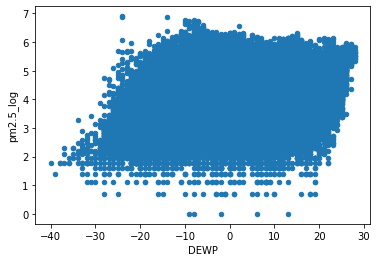

In [33]:
DEWP = pd.concat([no_nan_df['pm2.5_log'], no_nan_df['DEWP']], axis=1)
DEWP.plot.scatter(x='DEWP', y='pm2.5_log')

Temperature 温度 ('TEMP')。也即观察时对应的温度。

<AxesSubplot:xlabel='TEMP', ylabel='pm2.5_log'>

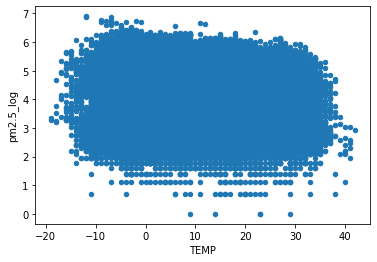

In [34]:
TEMP = pd.concat([no_nan_df['pm2.5_log'], no_nan_df['TEMP']], axis=1)
TEMP.plot.scatter(x='TEMP', y='pm2.5_log')

Pressure 压强 ('PRES')。也即观察时对应的压强。

<AxesSubplot:xlabel='PRES', ylabel='pm2.5_log'>

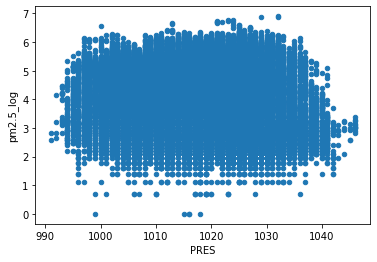

In [35]:
PRES = pd.concat([no_nan_df['pm2.5_log'], no_nan_df['PRES']], axis=1)
PRES.plot.scatter(x='PRES', y='pm2.5_log')

Cumulated wind speed 累积风速 ('Iws')。也即观察时对应的累积风速。

<AxesSubplot:xlabel='Iws', ylabel='pm2.5_log'>

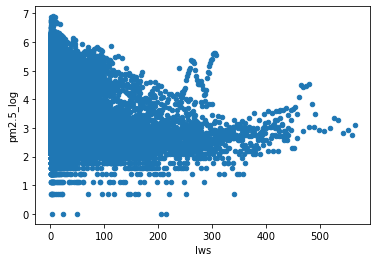

In [37]:
Iws = pd.concat([no_nan_df['pm2.5_log'], no_nan_df['Iws']], axis=1)
Iws.plot.scatter(x='Iws', y='pm2.5_log')

Cumulated hours of snow 累积降雪 ('Is')。也即观察时对应的累积降雪。

<AxesSubplot:xlabel='Is', ylabel='pm2.5_log'>

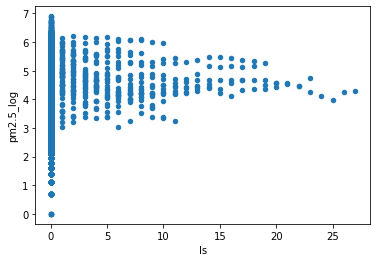

In [40]:
Is = pd.concat([no_nan_df['pm2.5_log'], no_nan_df['Is']], axis=1)
Is.plot.scatter(x='Is', y='pm2.5_log')

Cumulated hours of rain 累积降雨 ('Ir')。也即观察时对应的累积降雨。

<AxesSubplot:xlabel='Ir', ylabel='pm2.5_log'>

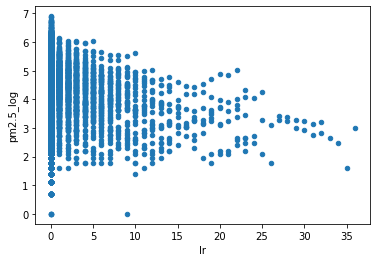

In [41]:
Ir = pd.concat([no_nan_df['pm2.5_log'], no_nan_df['Ir']], axis=1)
Ir.plot.scatter(x='Ir', y='pm2.5_log')

使用箱线图看看风向('cbwd')与pm2.5的关系。可以看出，在不同风向下，pm2.5的分布都比较稳定，但是吹西北风('NW')时，pm2.5的值都大体较小；而静风('cv')时，pm2.5的值都比较大。

(-0.5, 3.5, 0.0, 10.0)

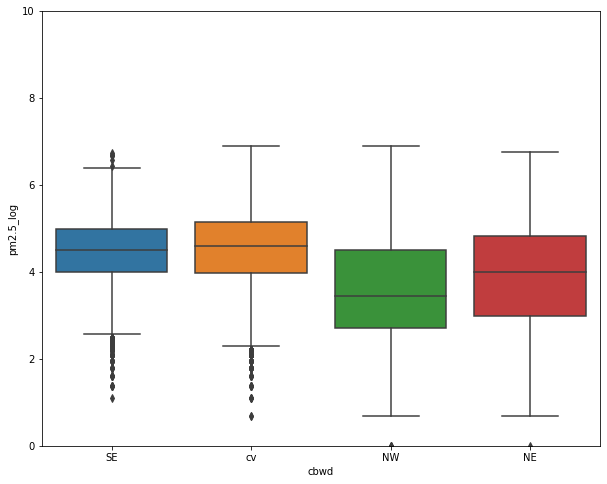

In [51]:
cbwd = pd.concat([no_nan_df['pm2.5_log'], no_nan_df['cbwd']], axis=1)
fig, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x='cbwd', y='pm2.5_log', data=cbwd)
fig.axis(ymin=0, ymax=10)

#### 2、相关性矩阵

由于有的数据没必要

<AxesSubplot:>

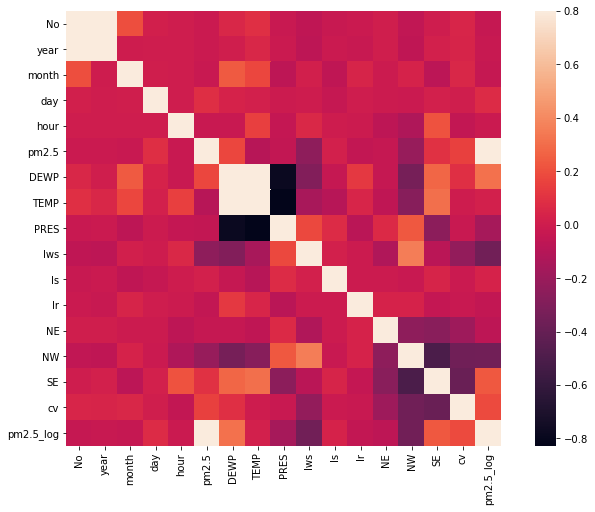

In [52]:
corr_mat = no_nan_df.corr()
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_mat, vmax=0.8, square=True)

由于特征太多，只看与pm2.5正相关和负相关各最强的5个特征（实际上是各4个，因为pm2.5与pm2.5_log是等价的）。

<AxesSubplot:>

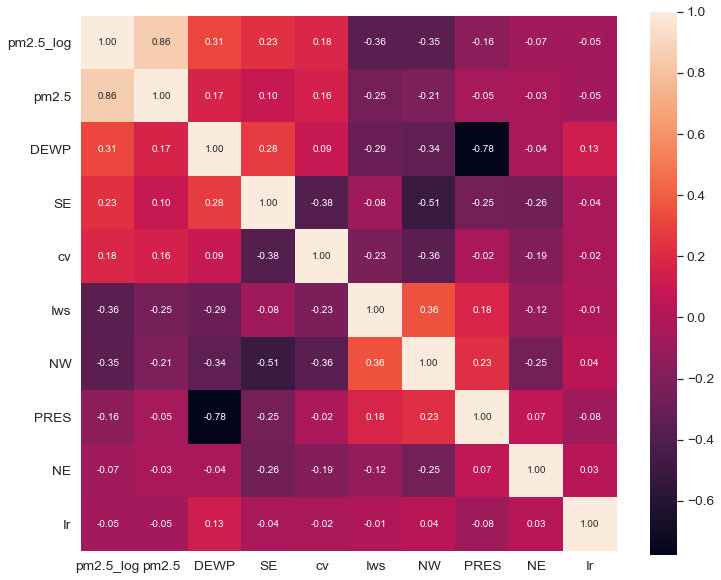

In [54]:
k = 5 # number of correlated features in heatmap
cols_large = corr_mat.nlargest(k, 'pm2.5_log')['pm2.5_log'].index 
cols_small = corr_mat.nsmallest(k, 'pm2.5_log')['pm2.5_log'].index 
cols =cols_large.append(cols_small)

cc = np.corrcoef(no_nan_df[cols].values.T)
sns.set(rc = {"figure.figsize":(12,10)}) 
sns.set(font_scale=1.25)
sns.heatmap(cc, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)